In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    LeakyReLU,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
)
from tensorflow.keras import layers, models


from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:


from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!ls "content/drive/My Drive/"


ls: cannot access 'content/drive/My Drive/': No such file or directory


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

print("Path to dataset files:", path)

100%|██████████| 225M/225M [00:11<00:00, 20.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2


In [5]:
# Install the Kaggle API
!pip install kaggle

# Create a Kaggle folder if it doesn't exist
!mkdir -p ~/.kaggle

In [6]:
# Copy the kaggle.json to the appropriate location
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"riwaj111111","key":"4f87d63a52c5d0f05857576ffd2abe2e"}'}

In [7]:
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # Change permissions

In [8]:
!kaggle datasets download alxmamaev/flowers-recognition/ -p /content/ --unzip


Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition/versions/
License(s): unknown
100% 224M/225M [00:11<00:00, 23.7MB/s]
100% 225M/225M [00:11<00:00, 21.2MB/s]


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths and parameters
data_dir = "/content/flowers"
image_shape = (224, 224)  # Resize all images to 224x224
batch_size = 64  # Batch size for loading data

# Initialize ImageDataGenerator for training/validation and test
train_valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Random shearing
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flips
    validation_split=0.125  # 10% out of the 80% data for validation (10/80 = 0.125)
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Only rescaling for test data

# Create training data generator (70% of the total dataset)
print("Training Images:")
train_data = train_valid_datagen.flow_from_directory(
    data_dir,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # Specify training subset (70% of total)
)

# Create validation data generator (10% of the total dataset)
print("Validating Images:")
valid_data = train_valid_datagen.flow_from_directory(
    data_dir,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # Specify validation subset (10% of total)
)

# Create test data generator (20% of the total dataset)
print("Test Images:")
test_data = test_datagen.flow_from_directory(
    data_dir,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Training Images:
Found 3779 images belonging to 5 classes.
Validating Images:
Found 538 images belonging to 5 classes.
Test Images:
Found 4317 images belonging to 5 classes.


In [11]:

# Extract class names from the datasets using class_indices
train_class_names = list(train_data.class_indices.keys())
valid_class_names = list(valid_data.class_indices.keys())
test_class_names = list(test_data.class_indices.keys())

# Print class names
print("Training Class Names:", train_class_names)
print("Validation Class Names:", valid_class_names)
print("Test Class Names:", test_class_names)

# Print the number of classes
print("Number of Training Classes:", len(train_class_names))
print("Number of Validation Classes:", len(valid_class_names))
print("Number of Test Classes:", len(test_class_names))

Training Class Names: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Validation Class Names: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Test Class Names: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Number of Training Classes: 5
Number of Validation Classes: 5
Number of Test Classes: 5


In [12]:
class_names = train_class_names


In [20]:
import tensorflow as tf

# 1. Create base model using ResNet50 from tf.keras.applications
base_model_resnet50 = tf.keras.applications.ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

# 2. Freeze the base model initially to retain pre-trained weights
base_model_resnet50.trainable = False

# 3. Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
], name="data_augmentation")

# 4. Create inputs for the model
inputs_resnet50 = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer_resnet50")

# 5. Apply data augmentation
x_resnet50 = data_augmentation(inputs_resnet50)

# 6. Pass the inputs through the base model
x_resnet50 = base_model_resnet50(x_resnet50)
print(f"Shape after base_model (ResNet50): {x_resnet50.shape}")  # Check the shape after passing through the base model

# 7. Add a Global Average Pooling layer
x_resnet50 = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer_resnet50")(x_resnet50)
print(f"Shape after GlobalAveragePooling2D() (ResNet50): {x_resnet50.shape}")

# 8. Add a fully connected (dense) layer
x_resnet50 = tf.keras.layers.Dense(256, activation='relu', name="dense_layer_resnet50")(x_resnet50)

# 9. Add a dropout layer
x_resnet50 = tf.keras.layers.Dropout(0.5, name="dropout_layer_resnet50")(x_resnet50)

# 10. Add the output layer for classification
# Adjust the number of units in the Dense layer to match your class count (e.g., 5 for 5 classes)
outputs_resnet50 = tf.keras.layers.Dense(5, activation="softmax", name="output_layer_resnet50")(x_resnet50)

# 11. Combine the inputs and outputs into a model
resnet50_model = tf.keras.Model(inputs_resnet50, outputs_resnet50)

# 12. Compile the model
resnet50_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

# 13. Learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7
)

# 14. Early stopping
early_stopping_resnet50 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)

# 15. Unfreeze the last few layers of the base model
for layer in base_model_resnet50.layers[-10:]:
    layer.trainable = True

# 16. Recompile the model after unfreezing layers
resnet50_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"]
)

# 17. Model summary
resnet50_model.summary()

# 18. Fit the model (adjust epochs and batch size as needed)
history_resnet50 = resnet50_model.fit(
    train_data,  # Replace with your training dataset
    validation_data=valid_data,  # Replace with your validation dataset
    epochs=50,
    batch_size=32,
    callbacks=[lr_scheduler, early_stopping_resnet50]
)


Shape after base_model (ResNet50): (None, 7, 7, 2048)
Shape after GlobalAveragePooling2D() (ResNet50): (None, 2048)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_resnet50 (InputLayer)    │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer_resnet… │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer_resnet50 (Dense)         │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer_resnet50 (Dropout)     │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer_resnet50 (Dense)        │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 4,991,493 (19.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.2083 - loss: 1.8218 - val_accuracy: 0.1766 - val_loss: 1.7900 - learning_rate: 1.0000e-05
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 65s 975ms/step - accuracy: 0.2788 - loss: 1.6397 - val_accuracy: 0.1784 - val_loss: 1.6536 - learning_rate: 1.0000e-05
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 64s 973ms/step - accuracy: 0.3091 - loss: 1.5617 - val_accuracy: 0.2138 - val_loss: 1.5876 - learning_rate: 1.0000e-05
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 65s 965ms/step - accuracy: 0.3374 - loss: 1.5152 - val_accuracy: 0.2454 - val_loss: 1.5463 - learning_rate: 1.0000e-05
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.3557 - loss: 1.4949 - val_accuracy: 0.4201 - val_loss: 1.4825 - learning_rate: 1.0000e-05
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 64s 976ms/step - accuracy: 0.3624 - loss: 1.4817 - val_accuracy: 0.4405 - val_loss: 1.4446 - learning_rate: 1.0000e-05
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.

In [21]:
resnet50_model.save('resnet50_model.keras')

# Testing and Evaluation

In [22]:
Y_pred = resnet50_model.predict(test_data)
score = resnet50_model.evaluate(test_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 277ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 250ms/step - accuracy: 0.6042 - loss: 1.0310
Test loss: 1.0462872982025146
Test accuracy: 0.5902246832847595


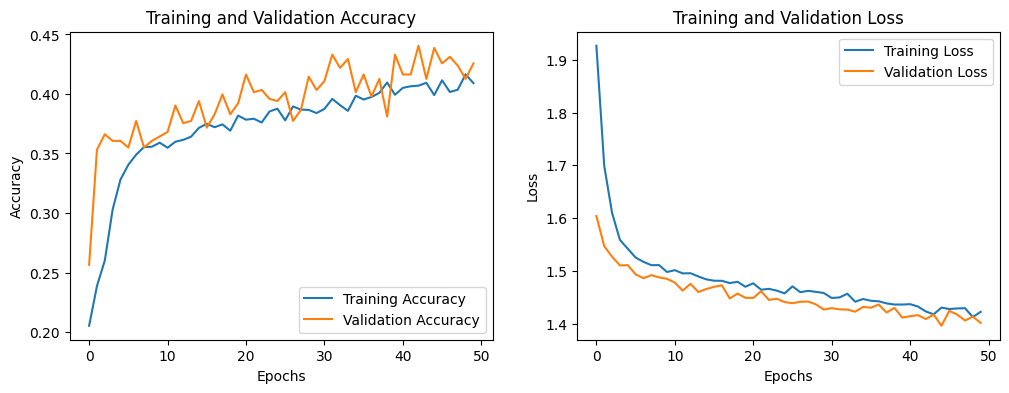

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np

# Define class names (replace these with actual class names if available)
CLASS_NAMES = class_names

# Function to plot accuracy and loss curves
def plot_training_curves(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# Call the function to plot curves
plot_training_curves(history)

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 690ms/step
Classification Report:
               precision    recall  f1-score   support

       daisy       0.54      0.56      0.55        95
   dandelion       0.60      0.76      0.67       131
        rose       0.38      0.34      0.35        98
   sunflower       0.59      0.55      0.57        91
       tulip       0.57      0.47      0.52       123

    accuracy                           0.54       538
   macro avg       0.53      0.53      0.53       538
weighted avg       0.54      0.54      0.54       538

Precision: 0.5394, Recall: 0.5446, F1 Score: 0.5385


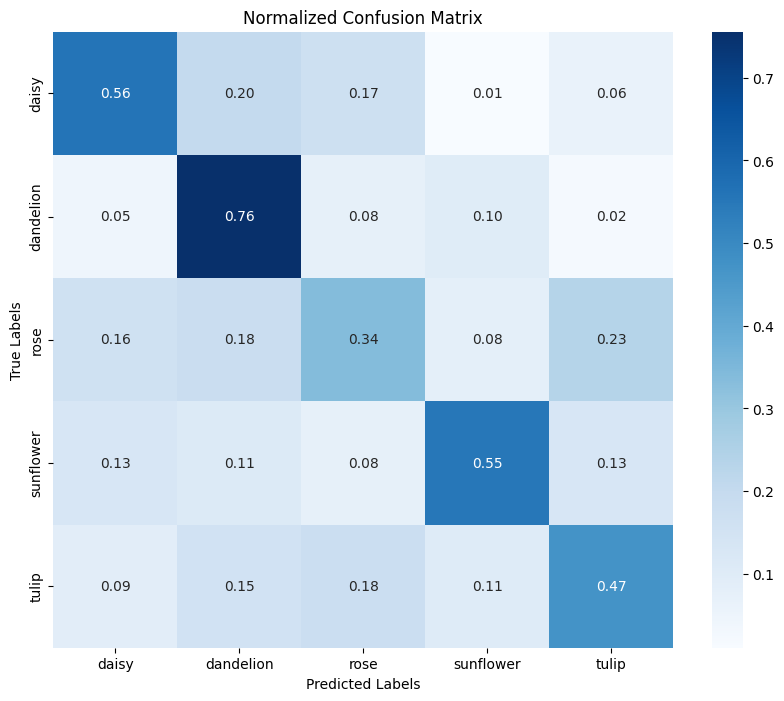

In [24]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Predict on validation data
Y_pred = resnet50_model.predict(valid_data)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = valid_data.classes  # Actual class labels from validation data

# Generate a classification report
CLASS_NAMES = list(valid_data.class_indices.keys())  # Extract class names from validation data generator
print("Classification Report:\n", classification_report(Y_true, Y_pred_classes, target_names=class_names))

# Calculate precision, recall, and F1-score
precision = precision_score(Y_true, Y_pred_classes, average='weighted')
recall = recall_score(Y_true, Y_pred_classes, average='weighted')
f1 = f1_score(Y_true, Y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

# Calculate normalized confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes, normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names, fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()


# GUI Implementation


In [25]:
import io
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import numpy as np
import tensorflow as tf

# Load your pre-trained model
model = resnet50_model  # Assuming your model is already loaded

# Define class names
CLASS_NAMES = class_names  # Use your actual class names here

# Function to preprocess and predict the image
def predict_image(img):
    img_resized = img.resize((224, 224))
    img_array = np.array(img_resized) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict and get confidence score
    predictions = model.predict(img_array)
    confidence_scores = predictions[0]
    pred_index = np.argmax(confidence_scores)
    pred_class = class_names[pred_index]
    pred_confidence = confidence_scores[pred_index]

    result_label.value = f"Prediction: {pred_class}\nConfidence: {pred_confidence:.2f}"

# Define widgets
upload_button = widgets.FileUpload(accept='image/*', multiple=False)
result_label = widgets.Label()

# Display the uploaded image and perform prediction
def on_upload_change(change):
    # Clear previous output (remove old image and result)
    clear_output(wait=True)

    # Re-display the upload button and result label
    display(widgets.VBox([upload_button, result_label]))

    for name, file_info in upload_button.value.items():
        image_data = io.BytesIO(file_info['content'])  # Convert binary content to a BytesIO object
        image = Image.open(image_data)  # Open image with PIL
        display(image)  # Display the uploaded image in the notebook
        predict_image(image)

upload_button.observe(on_upload_change, names='value')

# Display widgets
display(widgets.VBox([upload_button, result_label]))